In [1]:
# Check the PEP8 norm for each cell
%load_ext nb_black

<IPython.core.display.Javascript object>

P7 Description <br>

Mission: Implement a "credit scoring" tool to calculate the probability that a customer will repay their credit, then classify the request as credit granted or refused (or give a percentage). <br>

In this supervised classification problem, one of the first thing we can notice, looking up the database, is that the "target" class (1 for granted credits, 0 for rufused onces) is unbalanced.

For imbalanced class datasets, we need to either use specialized methods to change the dataset or change the learning algorithm to handle the skewed class distribution.

In this notebook, I'll deal with the feature selection / engineering part limited on the "application_train.csv". <br>
This notebook is partially based on [Will Koehrsen](href=https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook) kaggle work.

The procedure is as follow <br>
Select the meaningfull variables <br>
Preprocess the data <br>
Select models <br>
Apply a SMOTE oversampling / a Undersampling and compare if needed <br>
Compute the best model on the data with search of hyperparameters <br>

<a name="00"></a>
Part 1 - Data Analysis and feature engineering <br>
$\;\;\;\;\;\;$ [Unbalanced Target](#unbalance) <br>
$\;\;\;\;\;\;$ [Description of the database and missing data](#full) <br>
$\;\;\;\;\;\;$ [Removing missing columns > 57 %](#remove) <br>
$\;\;\;\;\;\;$ [Removing low variance columns](#varlow) <br>
$\;\;\;\;\;\;$ [Categorical variables](#categ) <br>
$\;\;\;\;\;\;$ [Feature Engineering](#feate) <br>
$\;\;\;\;\;\;$ [Target correlation](#correl) <br>
$\;\;\;\;\;\;$ [Model splitting X_train/test](#split) <br>
$\;\;\;\;\;\;$ [Filling missing values](#filling) <br>

#### For a fast reload you can tune the parameters here, when changing these, you might wanna double check if you are not dropping out some important fields

In [2]:
# Thresold in percent above witch the attributes with more missing values will be removed
user_defined_treshold_isna = 57
# Positive threshold under which attributs with lower variance will be removed
positive_threshold_var = 0.005
# Negative threshold under which attributs with lower variance will be removed
negative_threshold_var = 0.005
# positive correlation with the target threshold below which the attributes will be removed
cor_treshold_positive = 0.009
# negative correlation with the target threshold below which the attributes will be removed
cor_treshold_negative = 0.009

<IPython.core.display.Javascript object>

#### imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

<IPython.core.display.Javascript object>

In [4]:
import time

<IPython.core.display.Javascript object>

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Labelencoder
from sklearn import preprocessing

<IPython.core.display.Javascript object>

In [6]:
from statistics import mean

<IPython.core.display.Javascript object>

In [7]:
# split train/test
from sklearn import model_selection

<IPython.core.display.Javascript object>

In [8]:
from IPython.display import Image

<IPython.core.display.Javascript object>

#### data loading

In [9]:
# col width
pd.set_option("max_colwidth", 240)
# option to be able see all columns
pd.set_option("max_columns", None)
# max lanes display
pd.options.display.max_rows = 250

<IPython.core.display.Javascript object>

In [10]:
start = time.time()

df = pd.read_csv("application_train.csv")
desc = pd.read_csv("HomeCredit_columns_description_utf8.csv")

end = time.time()
print("total time: ", (end - start), "sec")

total time:  1.8633248805999756 sec


<IPython.core.display.Javascript object>

<a id='Full' />

## Description of the database

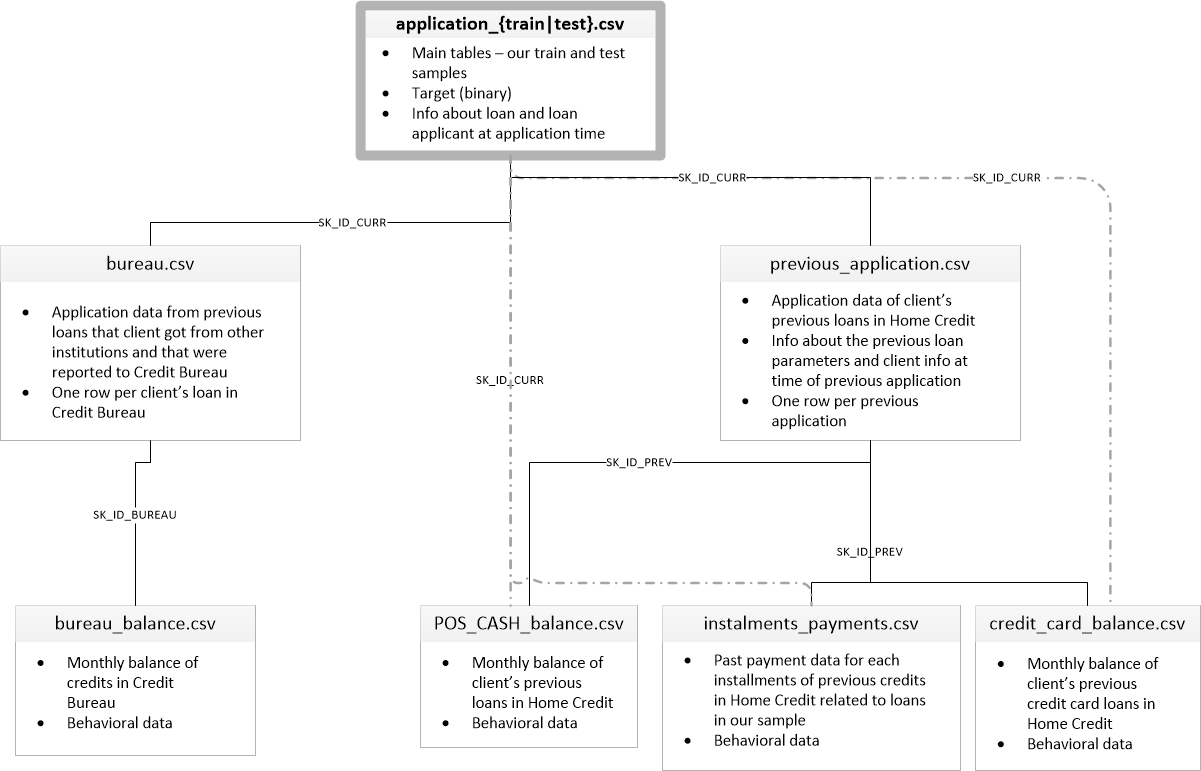

<IPython.core.display.Javascript object>

In [11]:
from IPython.display import Image

# notebook
Image("home_credit.png")

source : [Image by Will Koehrsen](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)

The application_train/application_test description is :
"application_{train|test}.csv <br>
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). <br>
Static data for all applications. One row represents one loan in our data sample." <br>

Since this project as not a competion goal, I'll stick with the application_train only.
The loan identification number is the SK_ID_CURR number. <br>
TARGET = 0: the loan was repaid / TARGET = 1: the loan was not repaid.

# PART 1 - Data Analysis and feature engineering

<a id='unbalance' />

### Unbalanced Target

In [12]:
def unbalanced_visu(df, cible="TARGET"):
    print("number of NaN in the dataframe :", df[cible].isna().sum())
    print("--" * 5)
    print(cible, "repartition in the dataframe :")
    print(df[cible].value_counts())
    print("--" * 5)
    print(
        "pourcentage target 1/0 :",
        ((df["TARGET"].value_counts()[1] * 100) / df["TARGET"].value_counts()[0]),
        "%",
    )
    # visualize the 'cible' variable
    g = sns.countplot(x=df[cible])
    g.set_xticklabels(["Good", "Bad"])
    plt.show()

<IPython.core.display.Javascript object>

number of NaN in the dataframe : 0
----------
TARGET repartition in the dataframe :
0    282686
1     24825
Name: TARGET, dtype: int64
----------
pourcentage target 1/0 : 8.781828601345662 %


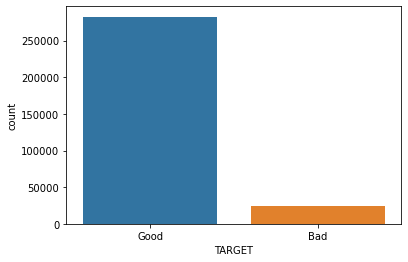

<IPython.core.display.Javascript object>

In [13]:
unbalanced_visu(df)

#### As we can see, the dataset is heavily unbalanced.

<a id='full' />

## Description of the database

In [14]:
df.shape

(307511, 122)

<IPython.core.display.Javascript object>

In [15]:
df.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<IPython.core.display.Javascript object>

In [16]:
df.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

<IPython.core.display.Javascript object>

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


<IPython.core.display.Javascript object>

In [18]:
desc["Description"].iloc[0:121].tolist()

['ID of loan in our sample',
 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'Identification if loan is cash or revolving',
 'Gender of the client',
 'Flag if the client owns a car',
 'Flag if client owns a house or flat',
 'Number of children the client has',
 'Income of the client',
 'Credit amount of the loan',
 'Loan annuity',
 'For consumer loans it is the price of the goods for which the loan is given',
 'Who was accompanying client when he was applying for the loan',
 'Clients income type (businessman, working, maternity leave,…)',
 'Level of highest education the client achieved',
 'Family status of the client',
 'What is the housing situation of the client (renting, living with parents, ...)',
 'Normalized population of region where client lives (higher number means the client lives in more populated region)',
 "Client's age in days a

<IPython.core.display.Javascript object>

In [19]:
df.head(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


<IPython.core.display.Javascript object>

In [20]:
col1 = list(df)

details = pd.DataFrame(col1, columns=["attributs"])

details["valeurs_manquantes"] = (df.isna().mean() * 100).tolist()
details["type"] = df.dtypes.tolist()
details["Com"] = desc["Description"].iloc[0:122].tolist()

<IPython.core.display.Javascript object>

In [21]:
left_aligned_details = details.sort_values(
    "valeurs_manquantes", ascending=False
).style.set_properties(**{"text-align": "left"})
left_aligned_details

,attributs,valeurs_manquantes,type,Com
76,COMMONAREA_MEDI,69.872297,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
48,COMMONAREA_AVG,69.872297,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
62,COMMONAREA_MODE,69.872297,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
70,NONLIVINGAPARTMENTS_MODE,69.432963,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
56,NONLIVINGAPARTMENTS_AVG,69.432963,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
84,NONLIVINGAPARTMENTS_MEDI,69.432963,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
86,FONDKAPREMONT_MODE,68.386172,object,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
68,LIVINGAPARTMENTS_MODE,68.354953,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
54,LIVINGAPARTMENTS_AVG,68.354953,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
82,LIVINGAPARTMENTS_MEDI,68.354953,float64,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"


<IPython.core.display.Javascript object>

In [22]:
# Removing SK_ID_CURR
df = df.set_index("SK_ID_CURR")
df.head(1)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


<IPython.core.display.Javascript object>

<a id='remove' />

### Removing missing values

For more advanced training or for algorithms like XGBoost, we can keep all the columns.
In this case, I choose to remove columns with more than 57 % missing values

In [23]:
col_isna = []
thresh = user_defined_treshold_isna

for i in range(df.shape[1]):
    if df[list(df)[i]].isna().mean() * 100 > thresh:
        col_isna.append(list(df)[i])

<IPython.core.display.Javascript object>

In [24]:
col_isna

['OWN_CAR_AGE',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

<IPython.core.display.Javascript object>

#### Please double check if any important fiels is not included in the dropping list !

In [25]:
print("old dimensions", df.shape)
print("--" * 5)
df = df.drop(col_isna, axis=1)
print("new dimension after removing missing values", df.shape)

old dimensions (307511, 121)
----------
new dimension after removing missing values (307511, 98)


<IPython.core.display.Javascript object>

In [26]:
df.dtypes.value_counts()

float64    43
int64      40
object     15
dtype: int64

<IPython.core.display.Javascript object>

<a id='varlow' /> 

### Removing attributs with low variance

In [27]:
ints = ["int16", "int32", "int64"]
floats = ["float16", "float32", "float64"]

df_ints = df.select_dtypes(include=ints)
df_floats = df.select_dtypes(include=floats)

<IPython.core.display.Javascript object>

In [28]:
print(df_ints.shape[1])
print(df_floats.shape[1])

40
43


<IPython.core.display.Javascript object>

In [29]:
df_ints.var(skipna=True).sort_values(ascending=False).tail(10)

FLAG_DOCUMENT_19    0.000595
FLAG_DOCUMENT_20    0.000507
FLAG_DOCUMENT_21    0.000335
FLAG_DOCUMENT_17    0.000267
FLAG_DOCUMENT_7     0.000192
FLAG_DOCUMENT_4     0.000081
FLAG_DOCUMENT_2     0.000042
FLAG_DOCUMENT_10    0.000023
FLAG_DOCUMENT_12    0.000007
FLAG_MOBIL          0.000003
dtype: float64

<IPython.core.display.Javascript object>

In [30]:
list_dropint = []

for i in range(df_ints.shape[1]):
    if df[list(df_ints)[i]].var() < positive_threshold_var:
        list_dropint.append(list(df_ints)[i])

<IPython.core.display.Javascript object>

In [31]:
list_dropint

['FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

<IPython.core.display.Javascript object>

#### Please double check if any important fiels is not included in the dropping list !

In [32]:
df_floats.var(skipna=True).sort_values(ascending=False).tail(10)

ENTRANCES_MEDI                  0.010074
ENTRANCES_AVG                   0.010010
AMT_REQ_CREDIT_BUREAU_HOUR      0.007031
NONLIVINGAREA_MODE              0.004936
NONLIVINGAREA_MEDI              0.004923
NONLIVINGAREA_AVG               0.004833
YEARS_BEGINEXPLUATATION_MODE    0.004170
YEARS_BEGINEXPLUATATION_MEDI    0.003588
YEARS_BEGINEXPLUATATION_AVG     0.003507
REGION_POPULATION_RELATIVE      0.000191
dtype: float64

<IPython.core.display.Javascript object>

In [33]:
list_dropfloat = []

for i in range(df_floats.shape[1]):
    if df[list(df_floats)[i]].var() < negative_threshold_var:
        list_dropfloat.append(list(df_floats)[i])

<IPython.core.display.Javascript object>

In [34]:
list_dropfloat

['REGION_POPULATION_RELATIVE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'NONLIVINGAREA_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'NONLIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'NONLIVINGAREA_MEDI']

<IPython.core.display.Javascript object>

#### Please double check if any important fiels is not included in the dropping list !

In [35]:
print("old dimensions", df.shape)
print("--" * 5)
df = df.drop(list_dropint, axis=1)
df = df.drop(list_dropfloat, axis=1)
print("new dimension after removing low variance attributs", df.shape)

old dimensions (307511, 98)
----------
new dimension after removing low variance attributs (307511, 75)


<IPython.core.display.Javascript object>

<a id='categ' />

## Categorical variables

In [36]:
df.dtypes.value_counts()

float64    36
int64      24
object     15
dtype: int64

<IPython.core.display.Javascript object>

In [37]:
df.select_dtypes("object").apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

<IPython.core.display.Javascript object>

In [38]:
df["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

<IPython.core.display.Javascript object>

For the columns with only 2 differents values, I'll use label encoder. <br> 
For the rest I'll use one hot encoding. <br> 
We have one specific case with the category "CODE_GENDER" where we have 4 XNA that I will remove.

In [39]:
print(df.shape)
print("--" * 5)
df = df[df["CODE_GENDER"] != "XNA"]
print(df.shape)

(307511, 75)
----------
(307507, 75)


<IPython.core.display.Javascript object>

#### LabelEncoder

In [40]:
le = preprocessing.LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == "object":
        # value_counts <= 2 we keep the na()s so we don't have 0-1-2 categories
        if len(list(df[col].unique())) <= 2:
            df[col] = le.fit_transform(df[col])
            print(col)

            # Keep track of how many columns were label encoded
            le_count += 1

print("%d columns were label encoded." % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
4 columns were label encoded.


<IPython.core.display.Javascript object>

As for example df["EMERGENCYSTATE_MODE"] is not encoded has it has na()s

In [41]:
df["EMERGENCYSTATE_MODE"].isna().mean() * 100

47.39859580432315

<IPython.core.display.Javascript object>

#### One hot encoder

In [42]:
print("old dimensions", df.shape)
print("--" * 5)
df = pd.get_dummies(df)
print("new dimensions after get dummies", df.shape)

old dimensions (307507, 75)
----------
new dimensions after get dummies (307507, 191)


<IPython.core.display.Javascript object>

<a id='feate' />

### Feature Engineering

In [43]:
numerics = ["float64"]
df2 = df.copy().select_dtypes(include=numerics)
df2["TARGET"] = df[["TARGET"]]
df2 = df2.dropna().sample(frac=0.001, random_state=1)

<IPython.core.display.Javascript object>

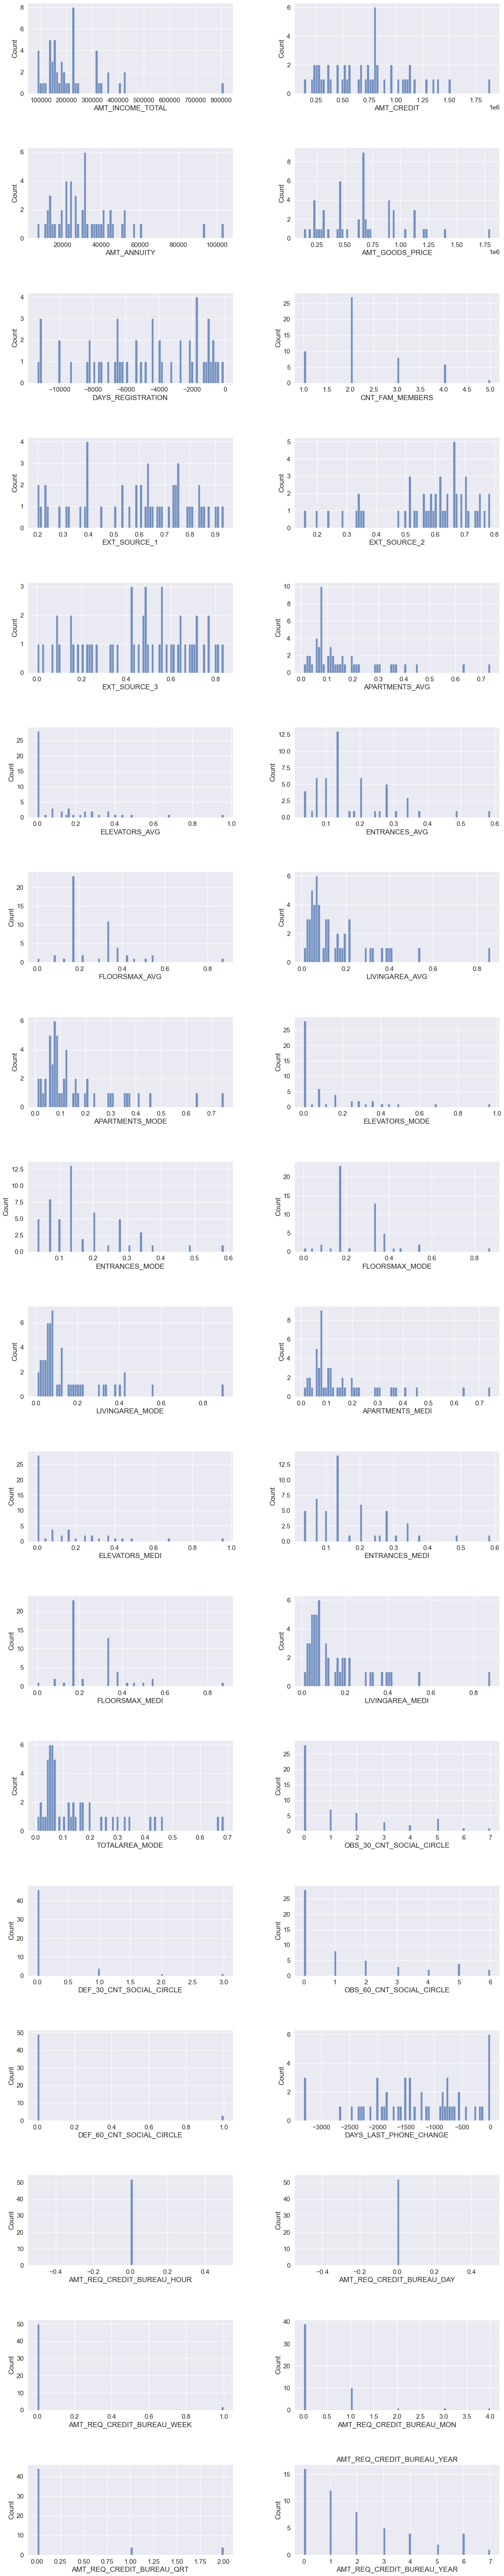

<IPython.core.display.Javascript object>

In [44]:
dfnl = list(df2)
dfnll = len(dfnl)
si = int(dfnll / 2)

sns.set(font_scale=1.4)


fig, axes = plt.subplots(ncols=2, nrows=si, figsize=(20, dfnll * 3))
fig.subplots_adjust(wspace=0.3, hspace=0.6)

nbins = 80

for i, ax in zip(range(dfnll), axes.flat):

    sns.histplot(
        data=df2[dfnl[i]].dropna(),
        kde=False,
        bins=nbins,
        log_scale=(False, False),
        ax=ax,
    )
    plt.title(dfnl[i])

In [45]:
# sns.set(font_scale=0.8)
# sns.pairplot(df2, height=2, hue="TARGET")

<IPython.core.display.Javascript object>

In [46]:
df2.head(1)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,APARTMENTS_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
347518,186885.0,720000.0,18990.0,720000.0,-8221.0,1.0,0.39356,0.517391,0.42413,0.1227,0.0,0.2759,0.1667,0.1131,0.125,0.0,0.2759,0.1667,0.1178,0.1239,0.0,0.2759,0.1667,0.1151,0.1218,5.0,2.0,5.0,1.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<IPython.core.display.Javascript object>

### Exploratory Data Analysis

In [47]:
(df["DAYS_EMPLOYED"] / -365).describe()

count    307507.000000
mean       -174.838162
std         387.058829
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Days Employment')

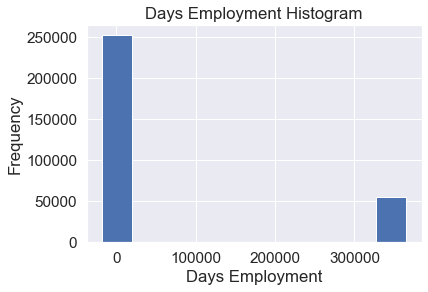

<IPython.core.display.Javascript object>

In [48]:
df["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment")

Text(0.5, 0, 'Days Employment')

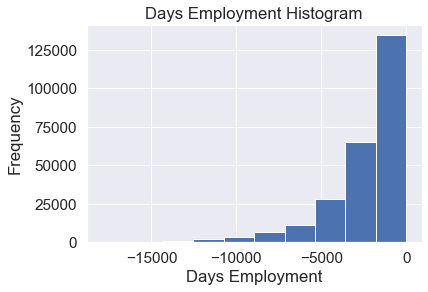

<IPython.core.display.Javascript object>

In [49]:
# Create an anomalous flag column
# df["DAYS_EMPLOYED_ANOM"] = df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

df["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment")

In [50]:
(df["DAYS_BIRTH"] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Days Birth')

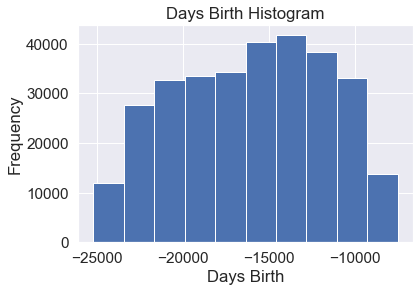

<IPython.core.display.Javascript object>

In [51]:
df["DAYS_BIRTH"].plot.hist(title="Days Birth Histogram")
plt.xlabel("Days Birth")

### New features

In [52]:
df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

<IPython.core.display.Javascript object>

In [53]:
df[
    [
        "DAYS_EMPLOYED_PERC",
        "INCOME_CREDIT_PERC",
        "INCOME_PER_PERSON",
        "ANNUITY_INCOME_PERC",
        "PAYMENT_RATE",
    ]
].describe()

,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,252133.000000,307507.000000,3.075050e+05,307495.000000,307495.000000
mean,0.156860,0.399669,9.310608e+04,0.180931,0.053695
std,0.133548,0.507927,1.013739e+05,0.094574,0.022481
min,-0.000000,0.011801,2.812500e+03,0.000224,0.022073
25%,0.056098,0.193802,4.725000e+04,0.114783,0.036900
50%,0.118733,0.306272,7.500000e+04,0.162833,0.050000
75%,0.219167,0.495376,1.125000e+05,0.229067,0.064043
max,0.728811,208.003328,3.900000e+07,1.875965,0.124430


<IPython.core.display.Javascript object>

### Removing outliers

In [88]:
# from scipy.stats import zscore

<IPython.core.display.Javascript object>

In [89]:
# # Remouving outliers
#     dft_0 = df[df["TARGET"] == 0]
#     dft_1 = df[df["TARGET"] == 1]

#     z_scores_0 = zscore(dft_0[numerical_columns])
#     z_scores_1 = zscore(dft_1[numerical_columns])

#     abs_z_scores_0 = np.abs(z_scores_0)
#     filtered_entries_0 = (abs_z_scores_0 < 3).all(axis=1)

#     abs_z_scores_1 = np.abs(z_scores_1)
#     filtered_entries_1 = (abs_z_scores_1 < 3).all(axis=1)

#     dft0 = dft_0[filtered_entries_0]
#     dft1 = dft_1[filtered_entries_1]
#     dft2 = pd.concat([dft0, dft1])

#     print("shape before removing outliers :", dft.shape)
#     print("shape after removing outliers :", dft2.shape)
#     print("--" * 5)

<IPython.core.display.Javascript object>

<a id='correl' />

### Target correlation

In [54]:
start = time.time()

correlation_t = []
names_cor = []
col_cor = list(df)

for i in range(df.shape[1]):
    correlation_t.append(df["TARGET"].corr(df[col_cor[i]]))
    names_cor.append(col_cor[i])

df_cor = pd.DataFrame(correlation_t, index=names_cor, columns=["Correlation"])


end = time.time()
print("total time: ", (end - start), "sec")

total time:  0.7594504356384277 sec


<IPython.core.display.Javascript object>

In [55]:
df_cor.shape

(196, 1)

<IPython.core.display.Javascript object>

In [56]:
df_cor = df_cor.dropna()

<IPython.core.display.Javascript object>

In [57]:
df_cor.shape

(196, 1)

<IPython.core.display.Javascript object>

In [58]:
df_cor.sort_values("Correlation", ascending=False, axis=0).head(15)

,Correlation
TARGET,1.000000
DAYS_BIRTH,0.078242
DAYS_EMPLOYED,0.074957
REGION_RATING_CLIENT_W_CITY,0.060895
REGION_RATING_CLIENT,0.058901
NAME_INCOME_TYPE_Working,0.057483
DAYS_LAST_PHONE_CHANGE,0.055219
CODE_GENDER,0.054710
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050992


<IPython.core.display.Javascript object>

In [59]:
df_cor.sort_values("Correlation", ascending=False, axis=0).tail(15)

,Correlation
ELEVATORS_MEDI,-0.033866
ELEVATORS_AVG,-0.034202
AMT_GOODS_PRICE,-0.039647
HOUSETYPE_MODE_block of flats,-0.040592
EMERGENCYSTATE_MODE_No,-0.042200
FLOORSMAX_MODE,-0.043231
FLOORSMAX_MEDI,-0.043773
FLOORSMAX_AVG,-0.044009
ORGANIZATION_TYPE_XNA,-0.045989
NAME_INCOME_TYPE_Pensioner,-0.046211


<IPython.core.display.Javascript object>

#### The range .00-.19 represent "very weak" correlations

In [60]:
drop_list = []
cor_treshp = cor_treshold_positive
cor_treshn = cor_treshold_negative

for i in range(df_cor.shape[0]):
    if cor_treshp > df_cor["Correlation"].iloc[i] < cor_treshn:
        drop_list.append(df_cor.index[i])

<IPython.core.display.Javascript object>

In [61]:
len(drop_list)

153

<IPython.core.display.Javascript object>

In [62]:
drop_list

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SU

<IPython.core.display.Javascript object>

In [63]:
# print("Old dimension", df.shape)
# print("--" * 5)
# df = df.drop(drop_list, axis=1)
# print("New dimensions after removing the less correlated variables", df.shape)

<IPython.core.display.Javascript object>

### Removing few attributs by hands

In [64]:
drop_list_hand = [
    "HOUR_APPR_PROCESS_START",
    "APARTMENTS_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "LIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "LIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "LIVINGAREA_MEDI",
    "TOTALAREA_MODE",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_18",
    "WEEKDAY_APPR_PROCESS_START_MONDAY",
    "WEEKDAY_APPR_PROCESS_START_SATURDAY",
    "WEEKDAY_APPR_PROCESS_START_SUNDAY",
    "WEEKDAY_APPR_PROCESS_START_THURSDAY",
    "WALLSMATERIAL_MODE_Block",
    "WALLSMATERIAL_MODE_Mixed",
    "WALLSMATERIAL_MODE_Monolithic",
    "WALLSMATERIAL_MODE_Others",
    "WALLSMATERIAL_MODE_Panel",
    "WALLSMATERIAL_MODE_Stone, brick",
    "EMERGENCYSTATE_MODE_No",
    "ORGANIZATION_TYPE_Advertising",
    "ORGANIZATION_TYPE_Agriculture",
    "ORGANIZATION_TYPE_Bank",
    "ORGANIZATION_TYPE_Business Entity Type 1",
    "ORGANIZATION_TYPE_Business Entity Type 2",
    "ORGANIZATION_TYPE_Cleaning",
    "ORGANIZATION_TYPE_Culture",
    "ORGANIZATION_TYPE_Electricity",
    "ORGANIZATION_TYPE_Emergency",
    "ORGANIZATION_TYPE_Government",
    "ORGANIZATION_TYPE_Hotel",
    "ORGANIZATION_TYPE_Housing",
    "ORGANIZATION_TYPE_Industry: type 1",
    "ORGANIZATION_TYPE_Industry: type 10",
    "ORGANIZATION_TYPE_Industry: type 11",
    "ORGANIZATION_TYPE_Industry: type 12",
    "ORGANIZATION_TYPE_Industry: type 13",
    "ORGANIZATION_TYPE_Industry: type 2",
    "ORGANIZATION_TYPE_Industry: type 4",
    "ORGANIZATION_TYPE_Industry: type 5",
    "ORGANIZATION_TYPE_Industry: type 6",
    "ORGANIZATION_TYPE_Industry: type 7",
    "ORGANIZATION_TYPE_Industry: type 8",
    "ORGANIZATION_TYPE_Industry: type 9",
    "ORGANIZATION_TYPE_Insurance",
    "ORGANIZATION_TYPE_Kindergarten",
    "ORGANIZATION_TYPE_Legal Services",
    "ORGANIZATION_TYPE_Medicine",
    "ORGANIZATION_TYPE_Military",
    "ORGANIZATION_TYPE_Mobile",
    "ORGANIZATION_TYPE_Other",
    "ORGANIZATION_TYPE_Police",
    "ORGANIZATION_TYPE_Postal",
    "ORGANIZATION_TYPE_Realtor",
    "ORGANIZATION_TYPE_Religion",
    "ORGANIZATION_TYPE_School",
    "ORGANIZATION_TYPE_Security",
    "ORGANIZATION_TYPE_Security Ministries",
    "ORGANIZATION_TYPE_Services",
    "ORGANIZATION_TYPE_Telecom",
    "ORGANIZATION_TYPE_Trade: type 1",
    "ORGANIZATION_TYPE_Trade: type 2",
    "ORGANIZATION_TYPE_Trade: type 3",
    "ORGANIZATION_TYPE_Trade: type 4",
    "ORGANIZATION_TYPE_Trade: type 5",
    "ORGANIZATION_TYPE_Trade: type 6",
    "ORGANIZATION_TYPE_Trade: type 7",
    "ORGANIZATION_TYPE_Transport: type 1",
    "ORGANIZATION_TYPE_Transport: type 2",
    "ORGANIZATION_TYPE_Transport: type 4",
    "ORGANIZATION_TYPE_University",
    "ORGANIZATION_TYPE_XNA",
]

<IPython.core.display.Javascript object>

In [65]:
print("Old dimension", df.shape)
print("--" * 5)
df = df.drop(drop_list_hand, axis=1)
# df = df.drop(drop_list_hand, axis=1, errors="ignore")
print("New dimensions after removing the less correlated variables", df.shape)

Old dimension (307507, 196)
----------
New dimensions after removing the less correlated variables (307507, 111)


<IPython.core.display.Javascript object>

In [66]:
list(df)

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_TYPE_SUITE_Children',
 

<IPython.core.display.Javascript object>

### Last removal of "unwanted categories"

In [67]:
drop_list_hand2 = [
    "WEEKDAY_APPR_PROCESS_START_FRIDAY",
    "WEEKDAY_APPR_PROCESS_START_TUESDAY",
    "WEEKDAY_APPR_PROCESS_START_WEDNESDAY",
    "ORGANIZATION_TYPE_Business Entity Type 3",
    "ORGANIZATION_TYPE_Construction",
    "ORGANIZATION_TYPE_Industry: type 3",
    "ORGANIZATION_TYPE_Restaurant",
    "ORGANIZATION_TYPE_Self-employed",
    "ORGANIZATION_TYPE_Transport: type 3",
    "HOUSETYPE_MODE_block of flats",
    "HOUSETYPE_MODE_specific housing",
    "HOUSETYPE_MODE_terraced house",
    "WALLSMATERIAL_MODE_Wooden",
    "DAYS_LAST_PHONE_CHANGE",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
]

<IPython.core.display.Javascript object>

In [68]:
print("Old dimension", df.shape)
print("--" * 5)
df = df.drop(drop_list_hand2, axis=1)
print("New dimensions after removing the less correlated variables", df.shape)

Old dimension (307507, 111)
----------
New dimensions after removing the less correlated variables (307507, 95)


<IPython.core.display.Javascript object>

#### Even if we set a very low threshold limit we are removing too many important attributs, such as AMT_CREDIT for example...

For specific model (linear) we could also drop variables (df.drop('TARGET', asxis = 1).corr()) with high correlation pair value but I will keep them for now.

-----------------------

<a id='split' />

### X_train / X_test

In [69]:
X0 = df.drop("TARGET", axis=1)
y0 = df["TARGET"]

<IPython.core.display.Javascript object>

In [70]:
X0.shape

(307507, 94)

<IPython.core.display.Javascript object>

In [71]:
X0.head(1)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,-9461,-637.0,-3648.0,-2120,1,0,1.0,2,2,0,0,0,0,0,0,0.083037,0.262949,0.139376,2.0,2.0,2.0,2.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749


<IPython.core.display.Javascript object>

In [72]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X0,
    y0,
    test_size=0.2,
    stratify=y0,
    random_state=18,  # 20% des données dans le jeu de test
)

<IPython.core.display.Javascript object>

<a id='filling' />

### Filling missing values

In [73]:
imp_median = IterativeImputer(
    random_state=0, initial_strategy="median", n_nearest_features=5, max_iter=50,
)

<IPython.core.display.Javascript object>

In [74]:
start = time.time()

X_train_fill = pd.DataFrame(
    imp_median.fit_transform(X_train),
    columns=list(X_train),
    index=X_train.index.to_list(),
)

end = time.time()
print("total time: ", (end - start), "sec")

total time:  52.901217222213745 sec


<IPython.core.display.Javascript object>

In [75]:
start = time.time()

X_test_fill = pd.DataFrame(
    imp_median.fit_transform(X_test),
    columns=list(X_test),
    index=X_test.index.to_list(),
)

end = time.time()
print("total time: ", (end - start), "sec")

total time:  2.6529619693756104 sec


<IPython.core.display.Javascript object>

In [76]:
X_test.shape

(61502, 94)

<IPython.core.display.Javascript object>

In [77]:
X_testna = X_test.copy()
print(X_testna.shape)
print("--" * 5)
X_testna["TARGET"] = y_test
print(X_testna.shape)
print("--" * 5)
X_testna = X_testna.dropna()
print(X_testna.shape)
print("--" * 5)
y_testna = X_testna["TARGET"]
X_testna = X_testna.drop("TARGET", axis=1)
print("X_test with no na :", X_testna.shape)
print("y_test with no na :", y_testna.shape)

(61502, 94)
----------
(61502, 95)
----------
(19543, 95)
----------
X_test with no na : (19543, 94)
y_test with no na : (19543,)


<IPython.core.display.Javascript object>

In [78]:
X_train_fill.to_csv("X_train.csv", index=True)
y_train.to_csv("y_train.csv", index=True)
X_test.to_csv("X_test.csv", index=True)
X_test_fill.to_csv("X_test_fill.csv", index=True)
X_testna.to_csv("X_test_na.csv", index=True)
y_test.to_csv("y_test.csv", index=True)
y_testna.to_csv("y_test_na.csv", index=True)

<IPython.core.display.Javascript object>

In [79]:
df_test_clean = X_testna.copy()
df_test_clean["TARGET"] = y_testna

<IPython.core.display.Javascript object>

number of NaN in the dataframe : 0
----------
TARGET repartition in the dataframe :
0    18084
1     1459
Name: TARGET, dtype: int64
----------
pourcentage target 1/0 : 8.067905330679054 %


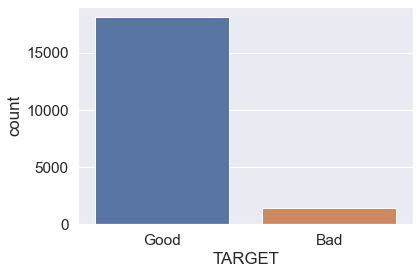

<IPython.core.display.Javascript object>

In [80]:
unbalanced_visu(df_test_clean)

In [81]:
X_train.shape

(246005, 94)

<IPython.core.display.Javascript object>

### Description of the different attributs

In [82]:
defcol = list(X_train)

<IPython.core.display.Javascript object>

In [83]:
df_defcol = pd.DataFrame(defcol, columns=["col name"])

<IPython.core.display.Javascript object>

In [84]:
df_defcol["Description"] = [
    "Cash or revolving type of loan",
    "Gender of the client",
    "1 if a client has a car",
    "" "1 if the client owns a house/flat",
    "Number of children the client has",
    "Income of the client",
    "Credit amount of the loan",
    "Loan annuity",
    "For consumer loans it is the price of the goods for which the loan is given",
    "Number of days since the birth of the client at the time of the application",
    "How many days before the application the person started current employment",
    "How many days before the application did client change his registration",
    "How many days before the application did client change the identity document with which he applied for the loan",
    "1 if the client provided a phone number",
    "1 if the client provided a email",
    "How many family members does client have",
    "Our rating of the region where client lives (1,2,3)",
    "Our rating of the region where client lives with taking city into account (1,2,3)",
    "1 if the client s contact address is different from the permanent client s adress (region)",
    "1 if the client s working address is different from the permanent client s adress (region)",
    "1 if the client s working address is different from the contact client s adress (region)",
    "1 if the client s contact address is different from the permanent client s adress (city)",
    "1 if the client s working address is different from the permanent client s adress (city)",
    "1 if the client s working address is different from the contact client s adress (city)",
    "Normalized score from external data source",
    "Normalized score from external data source",
    "Normalized score from external data source",
    "How many observation of client s social surroundings with observable 30 DPD (days past due) default",
    "How many observation of client's social surroundings defaulted on 30 DPD (days past due)",
    "How many observation of client's social surroundings with observable 60 DPD (days past due) default",
    "How many observation of client's social surroundings defaulted on 60 (days past due) DPD",
    "1 if client provided document 3",
    "Number of enquiries to Credit Bureau about the client one hour before applicatio",
    "Number of enquiries to Credit Bureau about the client one day before applicatio",
    "Number of enquiries to Credit Bureau about the client one week before applicatio",
    "Number of enquiries to Credit Bureau about the client one month before applicatio",
    "Number of enquiries to Credit Bureau about the client 3 month before applicatio",
    "Number of enquiries to Credit Bureau about the client one year before applicatio",
    "1 if the client was accompanied by a children",
    "1 if the client was accompanied by his family",
    "1 if the client was accompanied by a group of people",
    "1 if the client was accompanied by other_A",
    "1 if the client was accompanied by other B",
    "1 if the client was accompanied by a spouse/partner",
    "1 if the client was unaccompanied",
    "Clients income type : Businessman",
    "Clients income type : Commercial associate",
    "Clients income type : Maternity leave",
    "Clients income type : Pensioner",
    "Clients income type : State servant",
    "Clients income type : Student",
    "Clients income type : Unemployed",
    "Clients income type : Working",
    "Level of highest education the client achieved : Academic degree",
    "Level of highest education the client achieved : Higher education",
    "Level of highest education the client achieved : Incomplete higher",
    "Level of highest education the client achieved : Lower secondary",
    "Level of highest education the client achieved : Secondary / secondary special",
    "Family status of the client : Civil marriage",
    "Family status of the client : Married",
    "Family status of the client : Separated",
    "Family status of the client : Single / not married",
    "Family status of the client : Unknown",
    "Family status of the client : Widow",
    "What is the housing situation of the client : Co-op apartment",
    "What is the housing situation of the client : House / apartment",
    "What is the housing situation of the client : Municipal apartment",
    "What is the housing situation of the client : Office apartment",
    "What is the housing situation of the client : Rented apartment",
    "What is the housing situation of the client : With parents",
    "What kind of occupation does the client have : Accountants",
    "What kind of occupation does the client have : Cleaning staff",
    "What kind of occupation does the client have : Cooking staff",
    "What kind of occupation does the client have : Core staff",
    "What kind of occupation does the client have : Drivers",
    "What kind of occupation does the client have : HR staff",
    "What kind of occupation does the client have : High skill tech staff",
    "What kind of occupation does the client have : IT staff",
    "What kind of occupation does the client have : Laborers",
    "What kind of occupation does the client have : Low-skill Laborers",
    "What kind of occupation does the client have : Managers",
    "What kind of occupation does the client have : _Medicine staff",
    "What kind of occupation does the client have : Private service staff",
    "What kind of occupation does the client have : Realty agents",
    "What kind of occupation does the client have : Sales staff",
    "What kind of occupation does the client have : Secretaries",
    "What kind of occupation does the client have : Security staff",
    "What kind of occupation does the client have : Waiters/barmen staff",
    "Normalized information about building where the client lives : EMERGENCYSTATE_MODE",
    "Number of days employed in the current job (date of the application) / age of the client in days",
    "Percentage of the income that the credit represent",
    "Income per person of the family members",
    "Annuity of the Credit Bureau credit / Income of the client",
    "Annuity of the Credit Bureau credit / Amount of the loan",
]

<IPython.core.display.Javascript object>

In [85]:
df_defcol.head(3)

,col name,Description
0,NAME_CONTRACT_TYPE,Cash or revolving type of loan
1,CODE_GENDER,Gender of the client
2,FLAG_OWN_CAR,1 if a client has a car


<IPython.core.display.Javascript object>

In [86]:
df_defcol.to_csv("description.csv", index=True)

<IPython.core.display.Javascript object>